<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/Full_Linear_Evaluation_Imagenet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Thu Aug 20 04:36:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Restoring model weights from GCS Bucket

In [3]:
!wget https://storage.googleapis.com/resnet-simclr-pseudo-labels/resnet_simclr_modified_ae.h5

--2020-08-20 04:36:53--  https://storage.googleapis.com/resnet-simclr-pseudo-labels/resnet_simclr_modified_ae.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96848264 (92M) [application/octet-stream]
Saving to: ‘resnet_simclr_modified_ae.h5’

resnet_simclr_modif 100%[===================>]  92.36M   153MB/s    in 0.6s    

2020-08-20 04:36:54 (153 MB/s) - ‘resnet_simclr_modified_ae.h5’ saved [96848264/96848264]



In [2]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset gathering and preparation

In [7]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


In [3]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [4]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [5]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  5%|▌         | 13/250 [00:00<00:01, 126.07it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 202.29it/s]


(250, 224, 224, 3) (250,)


In [6]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [7]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [8]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('resnet_simclr_modified_ae.h5')
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [9]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [10]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [11]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 128) (250, 128)


In [12]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/100
20/20 [==============================] - 0s 7ms/step - loss: 5.9280 - accuracy: 0.2160 - val_loss: 3.4798 - val_accuracy: 0.2600
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 3.2917 - accuracy: 0.2496 - val_loss: 2.4136 - val_accuracy: 0.3360
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 2.3912 - accuracy: 0.3056 - val_loss: 1.8724 - val_accuracy: 0.4160
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 1.9129 - accuracy: 0.3448 - val_loss: 1.6187 - val_accuracy: 0.4320
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 1.6852 - accuracy: 0.3808 - val_loss: 1.5110 - val_accuracy: 0.4320
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 1.5869 - accuracy: 0.3928 - val_loss: 1.4563 - val_accuracy: 0.4520
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 1.5316 - accuracy: 0.3864 - val_loss: 1.4348 - val_accuracy: 0.4760
Epoch 8/100
2

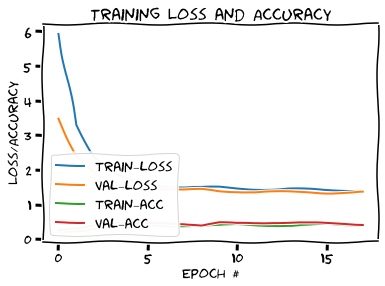

In [13]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [14]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 256) (250, 256)


Epoch 1/35
20/20 [==============================] - 0s 7ms/step - loss: 3.3614 - accuracy: 0.1816 - val_loss: 2.6662 - val_accuracy: 0.1920
Epoch 2/35
20/20 [==============================] - 0s 3ms/step - loss: 2.0647 - accuracy: 0.2464 - val_loss: 1.7858 - val_accuracy: 0.2960
Epoch 3/35
20/20 [==============================] - 0s 2ms/step - loss: 1.6179 - accuracy: 0.3288 - val_loss: 1.5058 - val_accuracy: 0.3800
Epoch 4/35
20/20 [==============================] - 0s 2ms/step - loss: 1.4715 - accuracy: 0.4064 - val_loss: 1.3920 - val_accuracy: 0.4840
Epoch 5/35
20/20 [==============================] - 0s 3ms/step - loss: 1.4292 - accuracy: 0.4176 - val_loss: 1.3564 - val_accuracy: 0.4760
Epoch 6/35
20/20 [==============================] - 0s 3ms/step - loss: 1.4243 - accuracy: 0.4096 - val_loss: 1.3411 - val_accuracy: 0.4680
Epoch 7/35
20/20 [==============================] - 0s 3ms/step - loss: 1.4072 - accuracy: 0.4248 - val_loss: 1.3399 - val_accuracy: 0.4520
Epoch 8/35
20/20 [==

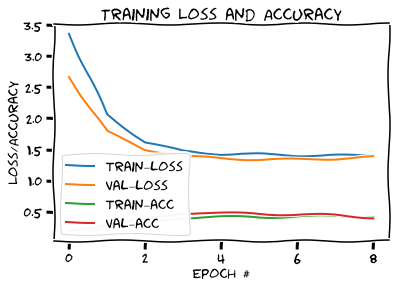

In [15]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [16]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 2048) (250, 2048)


Epoch 1/35
20/20 [==============================] - 0s 7ms/step - loss: 1.7752 - accuracy: 0.2832 - val_loss: 1.4539 - val_accuracy: 0.3920
Epoch 2/35
20/20 [==============================] - 0s 3ms/step - loss: 1.5132 - accuracy: 0.3960 - val_loss: 1.3733 - val_accuracy: 0.4600
Epoch 3/35
20/20 [==============================] - 0s 3ms/step - loss: 1.4242 - accuracy: 0.4264 - val_loss: 1.3397 - val_accuracy: 0.4720
Epoch 4/35
20/20 [==============================] - 0s 3ms/step - loss: 1.3873 - accuracy: 0.4536 - val_loss: 1.3248 - val_accuracy: 0.4080
Epoch 5/35
20/20 [==============================] - 0s 3ms/step - loss: 1.3518 - accuracy: 0.4456 - val_loss: 1.2997 - val_accuracy: 0.4760
Epoch 6/35
20/20 [==============================] - 0s 3ms/step - loss: 1.3925 - accuracy: 0.4360 - val_loss: 1.3114 - val_accuracy: 0.4760
Epoch 7/35
20/20 [==============================] - 0s 3ms/step - loss: 1.3583 - accuracy: 0.4352 - val_loss: 1.2602 - val_accuracy: 0.4680
Epoch 8/35
20/20 [==

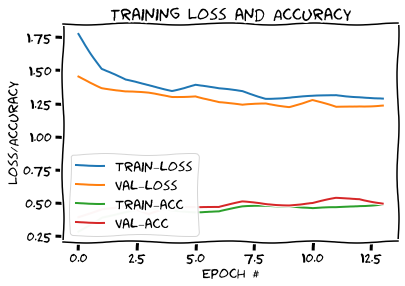

In [17]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)